<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/tesis/notebooks/08-seleccion_features_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selección de características mediante Regresión Logística

__Carrera:__ Maestria en Inteligencia de datos orientada a Big Data de la Universidad Nacional de La Plata.

___Título de la Tesis:___ Clasificación automática de correos electrónicos

___Autor:___ Juan Manuel Fernandez

___Director:___ Marcelo Errecalde

__Objetivo:__ En esta notebook se aplica la estrategia de selección de características basada en regresión logística para la identificación de términos y features representativos por clase.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [ ]:
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=4e5219d1282856f851d7ad67353a0a4b99c2fae826cda26ebe22c30dba88677c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [ ]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [ ]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

## Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [ ]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'correos-train-jaiio-80.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


## Regresión Logística

Se carga en memoria la función _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __LR__ y _representacion_documentos_ con la generación de las diferentes representaciones:

In [ ]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [ ]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BOW', 'TFIDF', '1-2-NGRAM-WORDS', 'BINARIO']
modelo = 'LR'
# Defino los parámetros para GridSearchCV
params_lr = {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100]}

### Ajuste del Modelo

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [ ]:
BUSQUEDA = False

if BUSQUEDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_lr, False, atr_consulta='consulta')

### Testeo del modelo

Se construye y testea el modelo en función de los mejores hiperparámetros encontrados:

In [ ]:
from funciones_dataset import consolidar_df
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Genero la representación de documentos
correos_train_vec, correos_test_vec = representacion_documentos(train_df['consulta'], test_df['consulta'], 'BINARIO', None)

# Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
x_train, y_train = consolidar_df(train_df, correos_train_vec, 'consulta', 'clase')
x_test, y_test = consolidar_df(test_df, correos_test_vec, 'consulta', 'clase')

# Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Instancio y entreno el modelo
clf = LogisticRegression(C=1)
clf.fit(x_train_scaled, y_train)

# Se realizan las predicciones sobre el conjunto de validación
y_predictions = clf.predict(x_test_scaled) 

# Calculo el accuracy sobre test
acc_test = accuracy_score(y_test, y_predictions)

print('Accuracy Test-Set: {}' . format(acc_test))

Accuracy Test-Set: 0.795


### Vector de coeficientes

Ahora se retornan los vectores de coeficientes para las clases:

In [ ]:
clf.coef_

array([[-0.281145  , -0.352999  , -0.08632148, ..., -0.0030534 ,
         0.09809831, -0.06000011],
       [ 0.22458227, -0.01718163,  0.00249835, ..., -0.00091426,
        -0.00145108, -0.0046253 ],
       [ 0.39617484, -0.0230432 , -0.1573813 , ..., -0.00083422,
        -0.00720678, -0.01689746],
       ...,
       [-0.69060374,  0.16308157, -0.09345261, ..., -0.00759692,
        -0.01456852, -0.01863601],
       [-0.20274742,  0.20988201, -0.02502822, ..., -0.0007436 ,
        -0.0012939 , -0.00402816],
       [ 0.45257571, -0.0793823 ,  0.40133357, ..., -0.00101505,
        -0.00504369, -0.01949491]])

Se instala la librería _mglearn_ para el ploteo de los términos importantes en función de los coeficientes:

In [ ]:
!pip install mglearn

     |████████████████████████████████| 540 kB 4.7 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=25aceae350831f5140078e718b38a8e07f6d816167b874594065d31d7187470a
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


Se construyen los plots por cada clase:



		Gráfico de ponderación de coeficientes de la LR para la clase Boleto Universitario


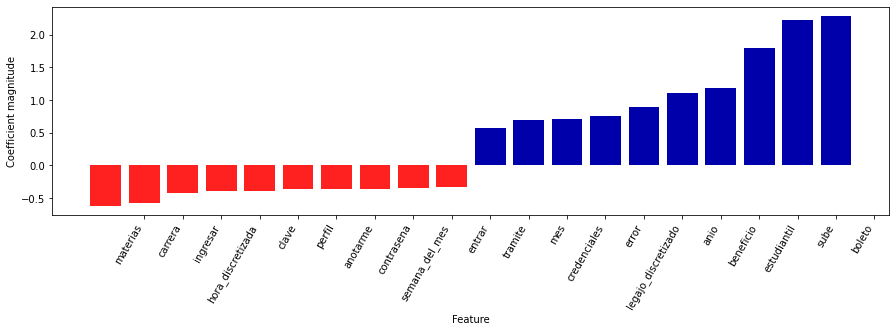



		Gráfico de ponderación de coeficientes de la LR para la clase Cambio de Carrera


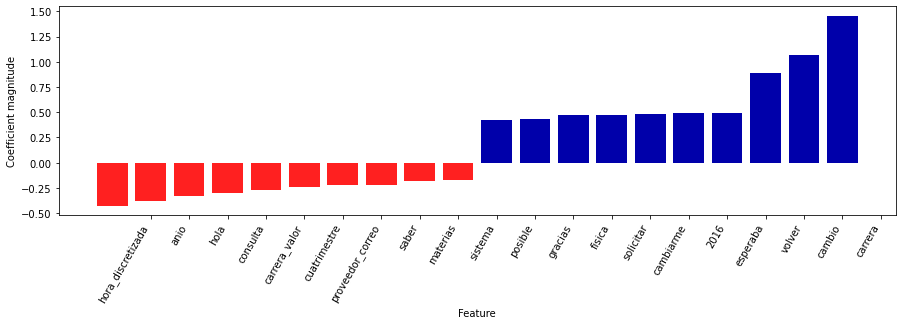



		Gráfico de ponderación de coeficientes de la LR para la clase Cambio de Comisión


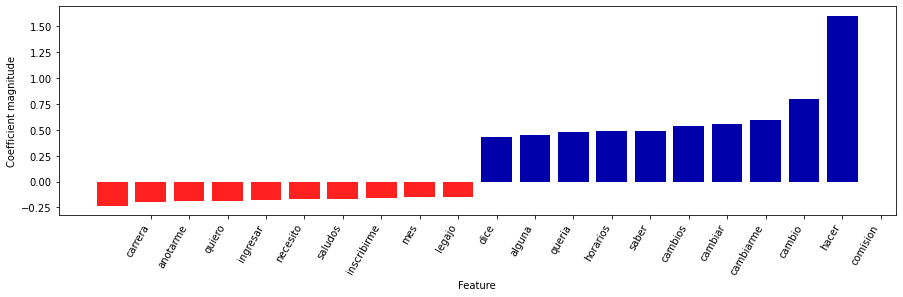



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta por Equivalencias


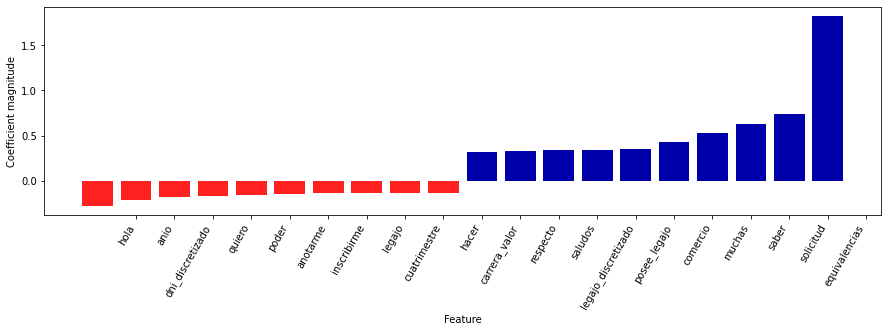



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta por Legajo


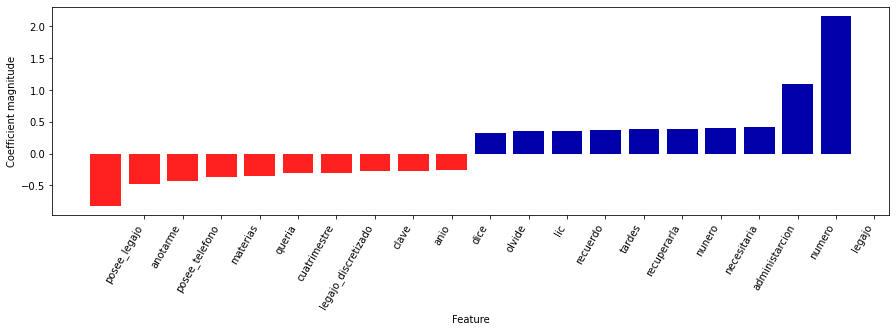



		Gráfico de ponderación de coeficientes de la LR para la clase Consulta sobre Título Universitario


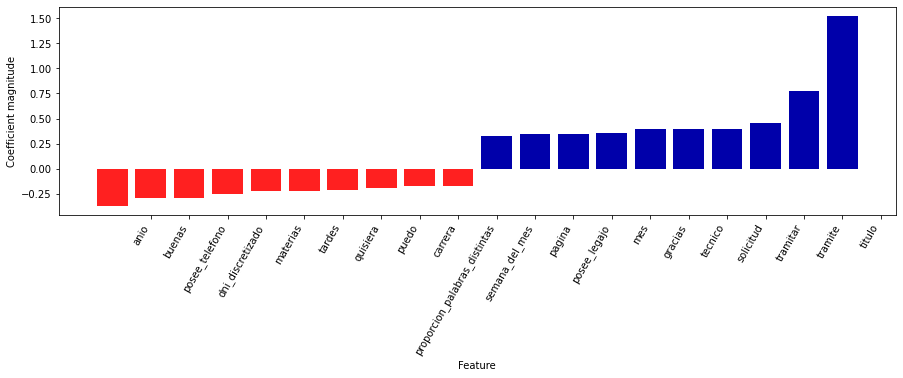



		Gráfico de ponderación de coeficientes de la LR para la clase Cursadas


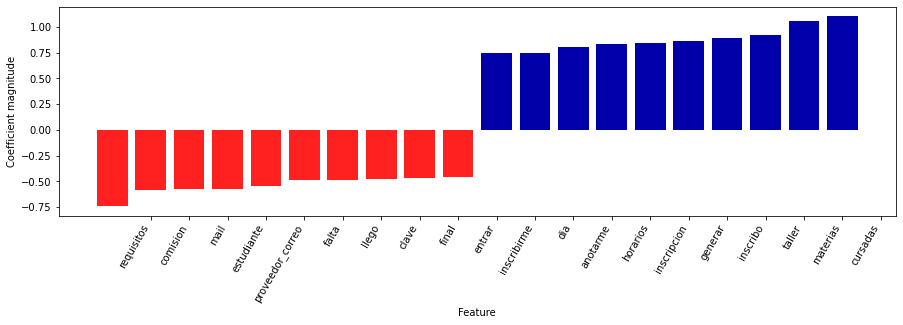



		Gráfico de ponderación de coeficientes de la LR para la clase Datos Personales


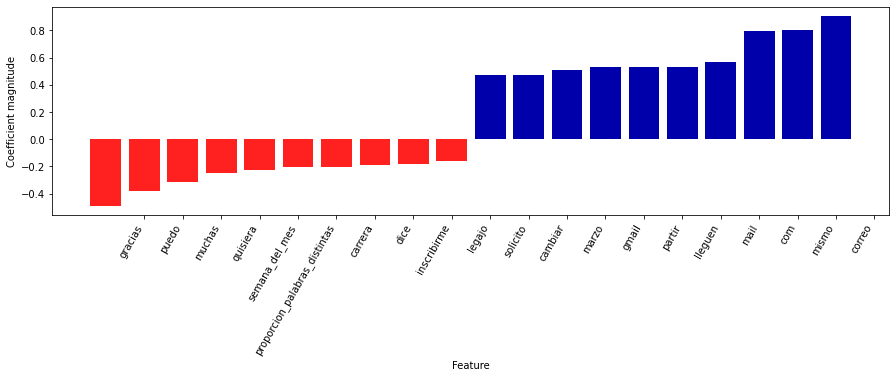



		Gráfico de ponderación de coeficientes de la LR para la clase Exámenes


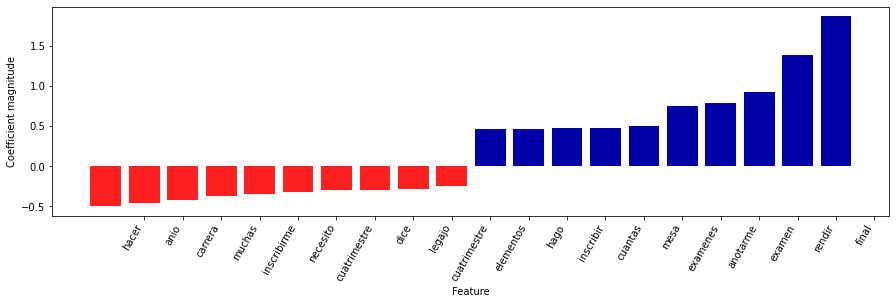



		Gráfico de ponderación de coeficientes de la LR para la clase Ingreso a la Universidad


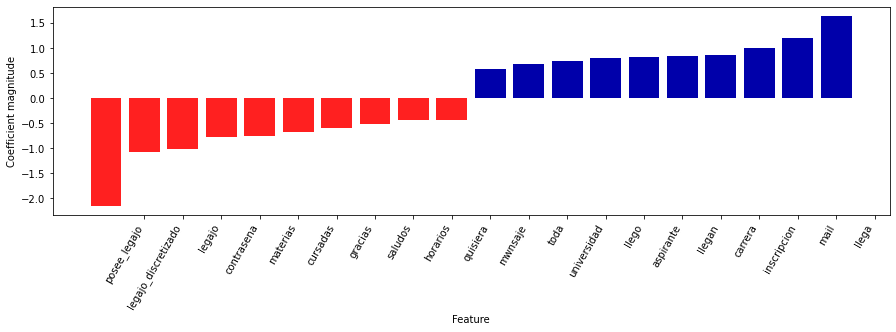



		Gráfico de ponderación de coeficientes de la LR para la clase Pedido de Certificados


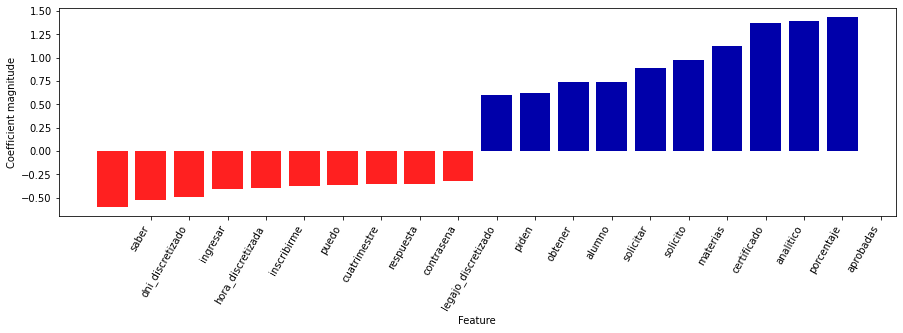



		Gráfico de ponderación de coeficientes de la LR para la clase Problemas con la Clave


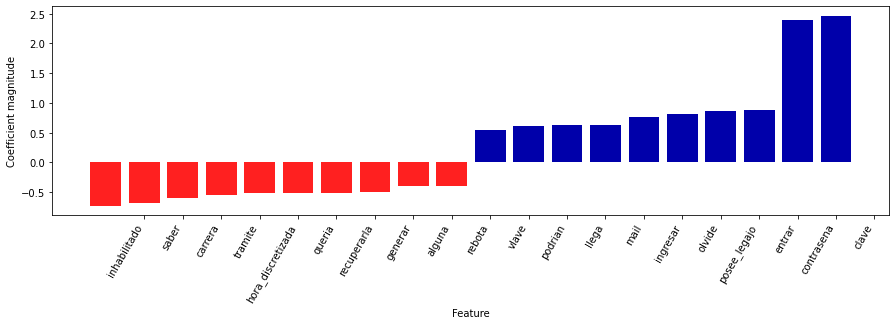



		Gráfico de ponderación de coeficientes de la LR para la clase Reincorporación


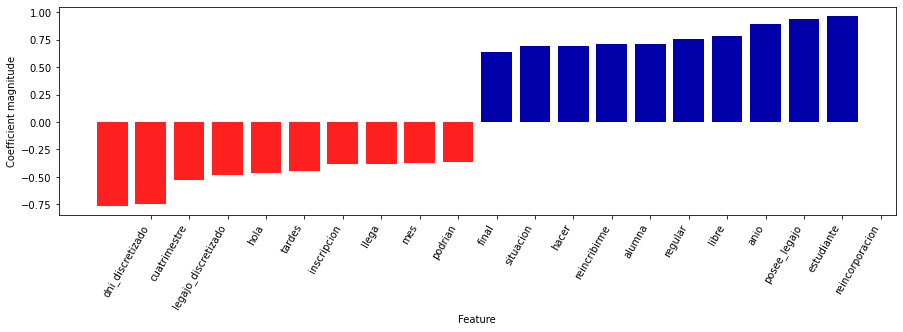



		Gráfico de ponderación de coeficientes de la LR para la clase Requisitos de Ingreso


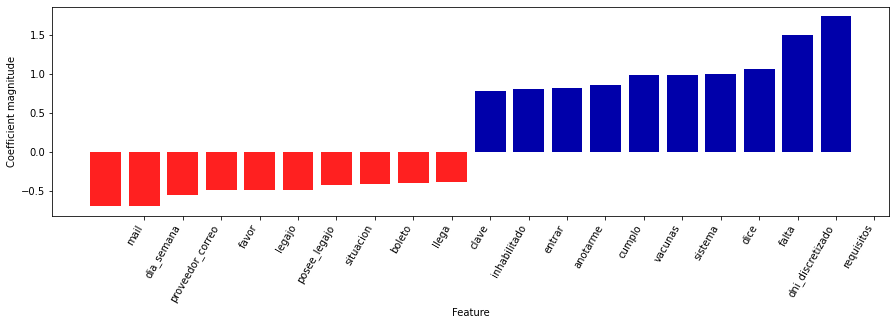



		Gráfico de ponderación de coeficientes de la LR para la clase Simultaneidad de Carreras


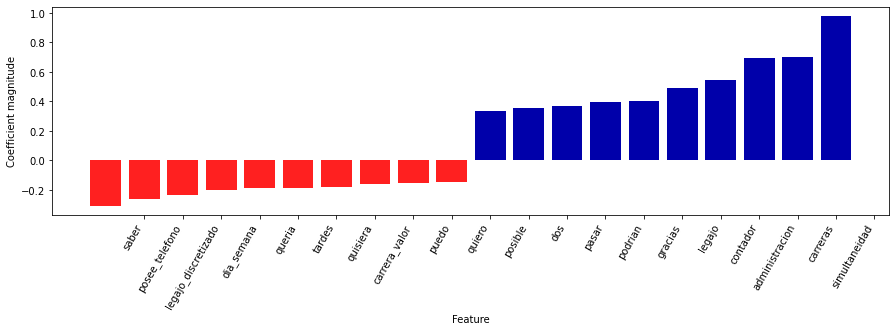



		Gráfico de ponderación de coeficientes de la LR para la clase Situación Académica


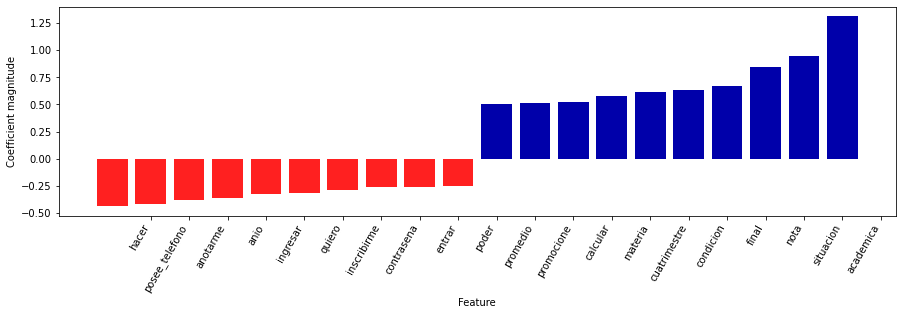

In [ ]:
from mglearn.tools import visualize_coefficients
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(len(etiquetas)):
  print(f'\n\n\t\tGráfico de ponderación de coeficientes de la LR para la clase {etiquetas[i]}')
  visualize_coefficients(clf.coef_[i], x_train.columns, n_top_features=10)
  # Muestro el gráfico
  plt.show()

## Términos representativos por clase

Ahora se genera un dataframe con los coeficientes por feature por clase:
- Filas: clase
- Columnas: términos

In [ ]:
import pandas as pd
import numpy as np

features = x_train.columns.values
#features = np.insert(features, 0, 'clase', axis=0)

df = pd.DataFrame(clf.coef_, columns=x_train.columns.values)
df['clase'] = pd.Series(etiquetas)
df.set_index('clase', inplace = True)

Ahora transpongo el dataframe:

In [ ]:
df_t = df.transpose()

df_t

clase,Boleto Universitario,Cambio de Carrera,Cambio de Comisión,Consulta por Equivalencias,Consulta por Legajo,Consulta sobre Título Universitario,Cursadas,Datos Personales,Exámenes,Ingreso a la Universidad,Pedido de Certificados,Problemas con la Clave,Reincorporación,Requisitos de Ingreso,Simultaneidad de Carreras,Situación Académica
dia_semana,-0.281145,0.224582,0.396175,0.105383,-0.199593,-0.073783,-0.190592,0.242429,0.063472,0.129562,-0.113740,-0.309354,0.447378,-0.690604,-0.202747,0.452576
semana_del_mes,-0.352999,-0.017182,-0.023043,0.073493,0.089381,0.322119,-0.080486,-0.230150,-0.012893,-0.436845,0.319550,0.173961,-0.118487,0.163082,0.209882,-0.079382
mes,-0.086321,0.002498,-0.157381,0.000897,-0.240578,0.355954,-0.179143,-0.046371,0.071272,-0.038130,0.175779,0.239360,-0.380688,-0.093453,-0.025028,0.401334
cuatrimestre,-0.260941,0.124277,0.014510,-0.134129,-0.313105,0.196591,0.249032,0.087947,-0.294541,0.405648,0.250349,-0.151191,-0.745907,-0.066164,0.020571,0.617053
anio,1.106808,-0.376693,-0.134190,-0.216433,-0.280025,-0.370727,0.028807,-0.137290,-0.457822,0.160634,-0.065556,0.271914,0.781254,0.188624,-0.139384,-0.359920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vuelvo,0.001254,-0.000038,-0.000018,-0.000018,-0.000019,-0.000070,-0.000036,-0.000030,-0.000027,-0.000151,-0.000051,-0.000161,-0.000029,-0.000160,-0.000043,-0.000402
web,-0.146833,-0.066905,-0.064750,-0.061494,-0.135001,0.032289,-0.022904,-0.069472,-0.108659,0.381920,0.084542,-0.078661,0.531700,-0.227936,-0.038278,-0.009560
wep,-0.003053,-0.000914,-0.000834,-0.000484,-0.004673,-0.000390,-0.010521,-0.005606,-0.003043,0.058541,-0.001302,-0.011991,-0.006373,-0.007597,-0.000744,-0.001015
xq,0.098098,-0.001451,-0.007207,-0.003258,-0.003086,-0.001634,-0.030768,-0.008740,-0.008355,-0.021215,-0.008609,0.035566,-0.018434,-0.014569,-0.001294,-0.005044


## Extracción de Features

Por último, se guardan los terminos que más impacto tienen para la clase positiva y negativa por cada clase.

En primer lugar, se crea la carpeta donde se persisten dos txt por clase, uno con los términos positivos (y su ponderación) y otro con los términos negativos:

In [ ]:
!mkdir txts_lr

Genero los txt con los términos más (y menos) importantes por clase:

In [ ]:
# Se define la cantidad de términos (positivos y negativos) a persistir por clase
N=10

# Recorro las clases una a una para obtener los términos más importantes
for clase in df_t.columns:
  
  # Tomo la columna del df que le corresponde a la clase
  clase_series = df_t[clase]

  # Genero un df con los términos y el valor
  terminos_clase = clase_series.to_frame()
  terminos_clase.reset_index(inplace=True)
  terminos_clase.columns = ['termino', 'valor']

  # Ordeno de forma descendente para quedarme con los más importantes
  ####################################################################
  terminos_clase.sort_values(by='valor', ascending=False, inplace=True)
  terminos_clase_pos = terminos_clase.head(N)
  terminos_clase_pos['clase'] = 'positivo'

  # Ordeno de forma ascendente para quedarme con los más importantes
  ####################################################################
  terminos_clase.sort_values(by='valor', ascending=True, inplace=True)
  terminos_clase_neg = terminos_clase.head(N)
  terminos_clase_neg['clase'] = 'negativo'

  # Juntamos positivos y negativos
  terminos_clase_total = pd.concat([terminos_clase_pos, terminos_clase_neg]).reset_index()

  # Guardo los términos menos importantes para la clase con su ponderación en un txt
  print(f'Se genera el txt con valores de la clase {clase}.')
  txt_name = "txts_lr/" + clase + ".txt"
  terminos_clase_total.to_csv(txt_name, sep=',', index=False)


Se genera el txt con valores de la clase Boleto Universitario.
Se genera el txt con valores de la clase Cambio de Carrera.
Se genera el txt con valores de la clase Cambio de Comisión.
Se genera el txt con valores de la clase Consulta por Equivalencias.
Se genera el txt con valores de la clase Consulta por Legajo.
Se genera el txt con valores de la clase Consulta sobre Título Universitario.
Se genera el txt con valores de la clase Cursadas.
Se genera el txt con valores de la clase Datos Personales.
Se genera el txt con valores de la clase Exámenes.
Se genera el txt con valores de la clase Ingreso a la Universidad.
Se genera el txt con valores de la clase Pedido de Certificados.
Se genera el txt con valores de la clase Problemas con la Clave.
Se genera el txt con valores de la clase Reincorporación.
Se genera el txt con valores de la clase Requisitos de Ingreso.
Se genera el txt con valores de la clase Simultaneidad de Carreras.
Se genera el txt con valores de la clase Situación Académic

In [ ]:
!ls txts_lr/

'Boleto Universitario.txt'		    Exámenes.txt
'Cambio de Carrera.txt'			   'Ingreso a la Universidad.txt'
'Cambio de Comisión.txt'		   'Pedido de Certificados.txt'
'Consulta por Equivalencias.txt'	   'Problemas con la Clave.txt'
'Consulta por Legajo.txt'		    Reincorporación.txt
'Consulta sobre Título Universitario.txt'  'Requisitos de Ingreso.txt'
 Cursadas.txt				   'Simultaneidad de Carreras.txt'
'Datos Personales.txt'			   'Situación Académica.txt'


Se zipea y se guarda en Google Drive:

In [ ]:
import shutil
shutil.make_archive('txts_lr', 'zip', 'txts_lr')

ENTORNO='Colab'
if ENTORNO=='Colab':
  from google.colab import drive
  drive.mount('drive')
  !cp txts_lr.zip "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05